# Bagging介绍

给定包含m个样本的数据集，我们先随机取出一个样本放入采样集中，再把该样本放回初始数据集，使得下次采样时该样本仍有可能被选中，这样，经过m次随机采样操作，我们得到含m个样本的采样集。照这样，我们可采样出T个包含m个训练样本的采样集，然后基于每个采样集训练出一个基学习器，再将这些基学习器进行结合。


Bagging算法描述

输入：训练集D={（x1,y1）,（x2,y2）,.......,(xm,ym)};

基学习算法£； 
     
训练轮数T；
过程：

1：for t=1,2,...,T do

2:    ht=£(D,Dbs)  #Dbs是自助采样产生的样本分布

3:end for

输出：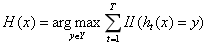

In [3]:
import numpy as np
import pandas as pd
import math
import random
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

In [32]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

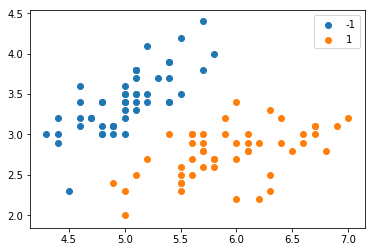

In [33]:
plt.scatter(X[:50,0],X[:50,1], label='-1')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

In [34]:
class baggingModel():
    def __init__(self,iterations=10,baseLearningAlgorithm='simpleClassify'):
        self.iterations=iterations  #训练轮数
        self.baseLearningAlgorithm=baseLearningAlgorithm  #基学习算法
        self.yCount={}
        self.weakClassifierArr=[]



    def train(self,Xtrain,ytrain):
        m,n=Xtrain.shape
        self.yCount=self.count_y(ytrain)
        ytrain=np.mat(ytrain)
        if self.baseLearningAlgorithm == 'simpleClassify':
            sc = simpleClassifyModel()
            for iter in range(self.iterations):
                Dbs,ybs=self.bootstrapSampling(Xtrain,ytrain)
                sc.train(Dbs,ybs)
                featIndex=sc.bestStump['featIndex']
                thresh=sc.bestStump['thresh']
                ineq=sc.bestStump['inequal']
                self.weakClassifierArr.append((featIndex,thresh,ineq))
        print("bagging train complete!")


    def count_y(self,y):
        dict={}
        for _ in y:
            if _ not in dict.keys():
                dict[_]=1
            else:
                dict[_]+=1
        return dict


    def bootstrapSampling(self,Xtrain,ytrain):
        m,n=Xtrain.shape
        bs=np.zeros((m,n))
        ybs=np.zeros((1,m))
        Dlist=range(m)
        for i in Dlist:
            j=random.choice(Dlist)
            bs[i,:]=Xtrain[j,:]
            ybs[0,i]=ytrain[0,j]
        return bs,ybs


    def predict(self,Xtest):
        bestY=math.inf
        bestH=-math.inf
        Xtest=np.mat(Xtest)
        if self.baseLearningAlgorithm == 'simpleClassify':
            predictSC=simpleClassifyModel()
            for y in self.yCount.keys():
                H=0
                for i in range(len(self.weakClassifierArr)):
                    predictVal=predictSC.predict(Xtest,self.weakClassifierArr[i][0],self.weakClassifierArr[i][1],self.weakClassifierArr[i][2])
                    if float(predictVal[0,0])==y:
                        H+=1
                if H>bestH:
                    bestH=H
                    bestY=y

        return bestY


    def score(self,Xtest,ytest):
        m = Xtest.shape[0]
        ytest=np.mat(ytest)
        predictVals = np.zeros((m, 1))
        for i in range(m):
            predictVals[i]=self.predict(Xtest[i])
        accuracy=(predictVals==ytest.T)
        accuracy=np.sum(accuracy)/m
        print("accuracy is ",accuracy*100)



class simpleClassifyModel():
    def __init__(self):
        self.bestStump={}


    def train(self,Xtrain,ytrain):
        m,n=Xtrain.shape
        ytrain=np.mat(ytrain)
        numSteps=10
        maxAccuracy=-math.inf
        bestFeatIndex=-1
        bestThresh=math.inf
        bestInEqual=None
        for i in range(n):
            rangeMin=np.min(Xtrain[:,i])
            rangeMax=np.max(Xtrain[:,i])
            stepSize=(rangeMax-rangeMin)/numSteps
            for j in range(-1,numSteps+1):
                for inequal in ['lt','gt']:
                    threshVal=rangeMin+j*stepSize
                    predictVals=self.predict(Xtrain,i,threshVal,inequal)
                    accuracy=np.sum(predictVals==ytrain.T)
                    if accuracy>maxAccuracy:
                        maxAccuracy=accuracy
                        bestFeatIndex=i
                        bestThresh=threshVal
                        bestInEqual=inequal

        self.bestStump['featIndex']=bestFeatIndex
        self.bestStump['thresh']=bestThresh
        self.bestStump['inequal']=bestInEqual
        print("fit complete!")


    def predict(self,X,featIndex,threshVal,inequal):
        m=X.shape[0]
        predictVals=np.ones((m,1))
        if inequal=='lt':
            predictVals[X[:,featIndex]<=threshVal]=-1
        else:
            predictVals[X[:,featIndex]>threshVal]=-1
        return predictVals


    def score(self,X,y):
        y=np.mat(y)
        m=X.shape[0]
        predictVals=self.predict(X,self.bestStump['featIndex'],self.bestStump['thresh'],self.bestStump['inequal'])
        accuracy = (predictVals == y.T)
        accuracy = np.sum(accuracy) / m
        print("accuracy is ", accuracy*100)

In [35]:
mySC=simpleClassifyModel()
mySC.train(X_train,y_train)

print("without bagging training accuracy:")
mySC.score(X_train,y_train)

print("without bagging testing accuracy:")
mySC.score(X_test,y_test)

fit complete!
without bagging training accuracy:
accuracy is  88.75
without bagging testing accuracy:
accuracy is  90.0


In [36]:
myBG=baggingModel()
myBG.train(X_train,y_train)
print("with bagging training accuracy:")
myBG.score(X_train,y_train)
print("with bagging testing accuracy:")
myBG.score(X_test,y_test)

fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
bagging train complete!
with bagging training accuracy:
accuracy is  92.5
with bagging testing accuracy:
accuracy is  95.0
